In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import axes
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

RANDOM_STATE = 55

In [169]:
df = pd.read_csv('C:\\Users\\KIIT\\Downloads\\Cancer_data.csv')


As advised that the 'id' column is not a predicitve feature , it should be dropped/removed

->First make a copy of the original file

->then drop the id column 

->save the cleaned data as new file

In [170]:
dfn = df.copy()
dfn=dfn.drop('id',axis=1)

Let's save the csv file without id

In [171]:
#dfn.to_csv('final_cancer_data.csv', index=False)

Perform one hot encoding to convert M/B into numerical values

In [172]:
dfn.groupby('diagnosis').describe()

radius_mean                                                      \
                count       mean       std     min     25%     50%    75%   
diagnosis                                                                   
B               357.0  12.146524  1.780512   6.981  11.080  12.200  13.37   
M               212.0  17.462830  3.203971  10.950  15.075  17.325  19.59   

                 texture_mean             ... fractal_dimension_worst          \
             max        count       mean  ...                     75%     max   
diagnosis                                 ...                                   
B          17.85        357.0  17.914762  ...                0.085410  0.1486   
M          28.11        212.0  21.604906  ...                0.102625  0.2075   

          Unnamed: 32                               
                count mean std min 25% 50% 75% max  
diagnosis                                           
B                 0.0  NaN NaN NaN NaN NaN NaN NaN  
M                 0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 248 columns]

In [173]:
impfeatures = ['radius_mean', 'texture_mean', 'perimeter_mean']
print(dfn[impfeatures].describe())

       radius_mean  texture_mean  perimeter_mean
count   569.000000    569.000000      569.000000
mean     14.127292     19.289649       91.969033
std       3.524049      4.301036       24.298981
min       6.981000      9.710000       43.790000
25%      11.700000     16.170000       75.170000
50%      13.370000     18.840000       86.240000
75%      15.780000     21.800000      104.100000
max      28.110000     39.280000      188.500000


Histograms of key features

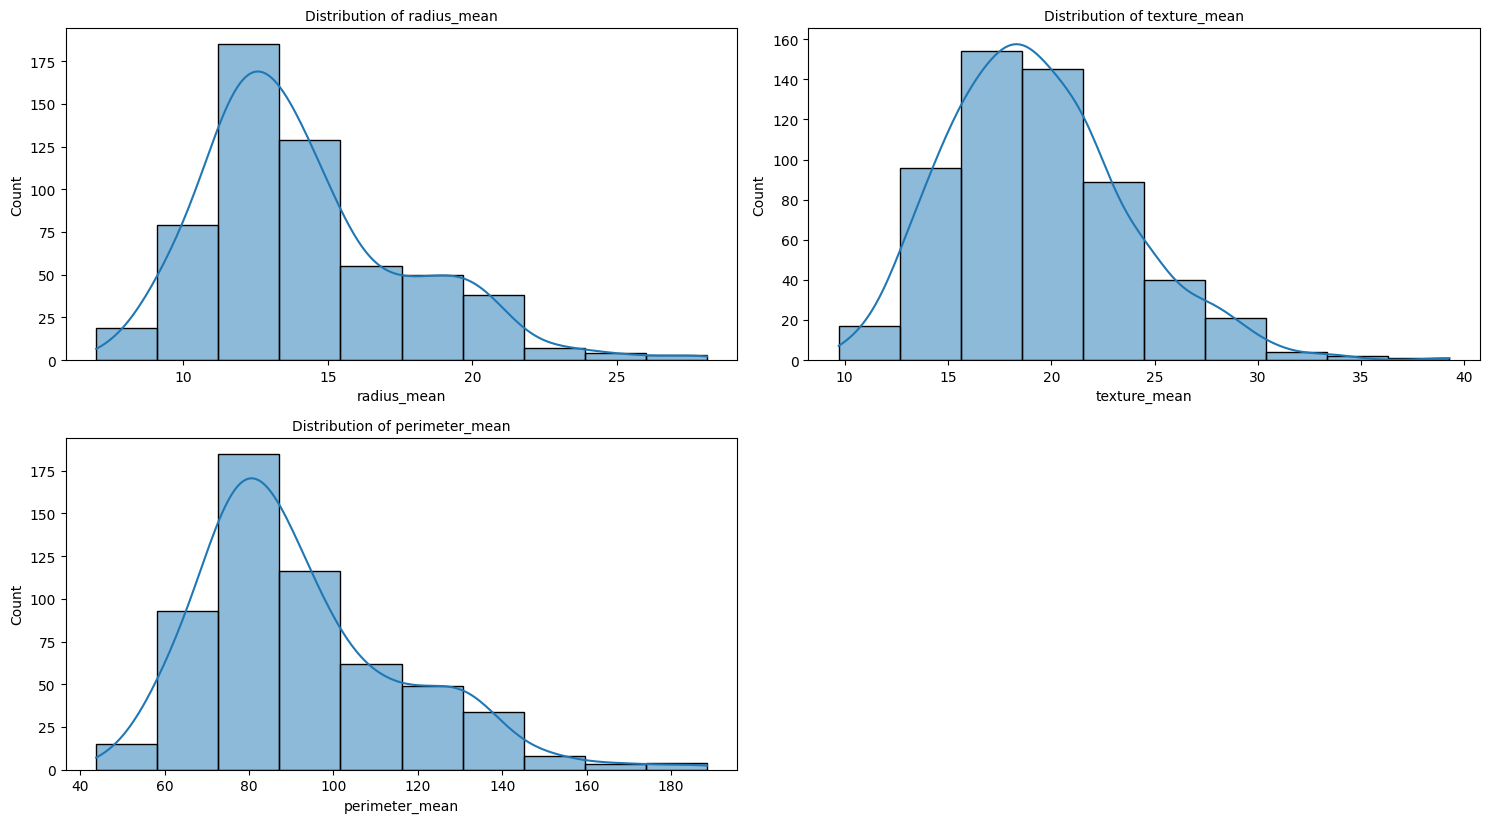

In [174]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(impfeatures, 1):
    plt.subplot(3, 2, i)
    sns.histplot(dfn[feature], kde=True, bins=10)
    plt.title(f'Distribution of {feature}', fontsize=10)
plt.tight_layout()
plt.show()

Box-Plots

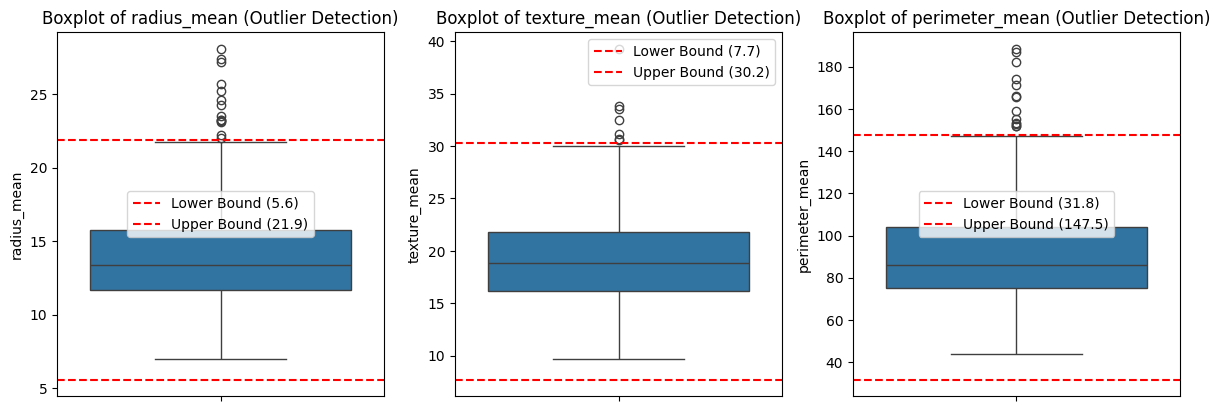

In [175]:
plt.figure(figsize=(12, 8))
for i, fr in enumerate(impfeatures, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=dfn[fr])
    plt.title(f'Boxplot of {fr} (Outlier Detection)')
    q1 = dfn[fr].quantile(0.25)
    q3 = dfn[fr].quantile(0.75)
    IQR = q3 - q1
    lbound = q1 - 1.5 * IQR
    ubound = q3 + 1.5 * IQR
    plt.axhline(y=lbound, color='r', linestyle='--', label=f'Lower Bound ({lbound:.1f})')
    plt.axhline(y=ubound, color='r', linestyle='--', label=f'Upper Bound ({ubound:.1f})')
    plt.legend()
plt.tight_layout()
plt.show()


C:\Users\KIIT\AppData\Local\Temp\ipykernel_14132\4042239669.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dfn, x='diagnosis', palette=['pink', 'lightblue'],legend=False)


<Axes: xlabel='diagnosis', ylabel='count'>

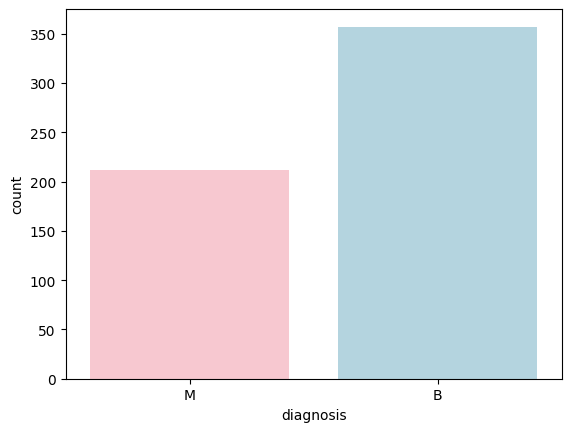

In [211]:
sns.countplot(data=dfn, x='diagnosis', palette=['pink', 'lightblue'],legend=False)

Before encoding

In [177]:
df['diagnosis'].value_counts(dropna=False)

diagnosis
B    357
M    212
Name: count, dtype: int64

After encoding

In [178]:
diagnosis_mapping = {'M': 1, 'B': 0}
#encoding applied
dfn['diagnosis_encoded'] = dfn['diagnosis'].map(diagnosis_mapping)
print(f"Value counts after encoding:\n{dfn['diagnosis_encoded'].value_counts()}")
print(f"Percentage distribution:\n{dfn['diagnosis_encoded'].value_counts(normalize=True) * 100}")



Value counts after encoding:
diagnosis_encoded
0    357
1    212
Name: count, dtype: int64
Percentage distribution:
diagnosis_encoded
0    62.741652
1    37.258348
Name: proportion, dtype: float64


Handle on the missing values and impute the missing value

In [179]:
outcomecount = dfn['diagnosis'].value_counts()
outcomepercentage = dfn['diagnosis'].value_counts(normalize=True) * 100#representation of percentage value

balance = pd.DataFrame({
    'Count': outcomecount,
    'Percentage': outcomepercentage.round(3)
}).sort_index()
print("Class Balance Summary:\n", balance)

# imbalance ratio (majority / minority)
imbalanceratio = outcomecount.max() / outcomecount.min()
print(f"\nImbalance Ratio (Majority/Minority): {imbalanceratio:.2f}")

Class Balance Summary:
            Count  Percentage
diagnosis                   
B            357      62.742
M            212      37.258

Imbalance Ratio (Majority/Minority): 1.68


Moderate Imbalance

 A 1.68 ratio indicates noticeable disparity—stronger than mild (1.0-1.5) but manageable, unlike severe cases (e.g., >5:1 in fraud detection). The dataset favors benign predictions, which is clinically realistic (most screenings are negative), but it risks under-detecting cancers if unaddressed.

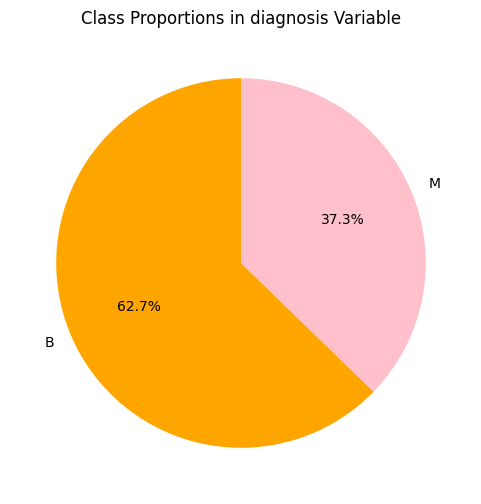

In [212]:
plt.figure(figsize=(6, 6))
plt.pie(outcomepercentage.values, labels=outcomepercentage.index, autopct='%1.1f%%', 
        colors=['orange', 'pink'], startangle=90)
plt.title('Class Proportions in diagnosis Variable')
plt.show()

In [181]:
#detect zeros
print("\nZero Counts (Likely Missings) ")
zero_counts = (dfn == 0).sum()
print("Zeros per column:\n", zero_counts)
print("\nZero percentage:\n", (zero_counts / len(dfn)) * 100)



Zero Counts (Likely Missings) 
Zeros per column:
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean              13
concave points_mean         13
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                13
concave points_se           13
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst             13
concave points_worst        13
symmetry_worst               0
fractal_dimension_w

In [182]:
missing_df = pd.DataFrame({
    'Column': zero_counts.index,
    'Missing Count': zero_counts.values,
    'Missing %': ((zero_counts/len(dfn))*100).values
}).sort_values('Missing Count', ascending=False)

In [183]:
print(missing_df[missing_df['Missing Count'] > 0])

                  Column  Missing Count  Missing %
32     diagnosis_encoded            357  62.741652
18     concave points_se             13   2.284710
7         concavity_mean             13   2.284710
17          concavity_se             13   2.284710
8    concave points_mean             13   2.284710
27       concavity_worst             13   2.284710
28  concave points_worst             13   2.284710


In [184]:
total_missing = zero_counts.sum()
print(f"\nTotal missing values: {total_missing}")


Total missing values: 435


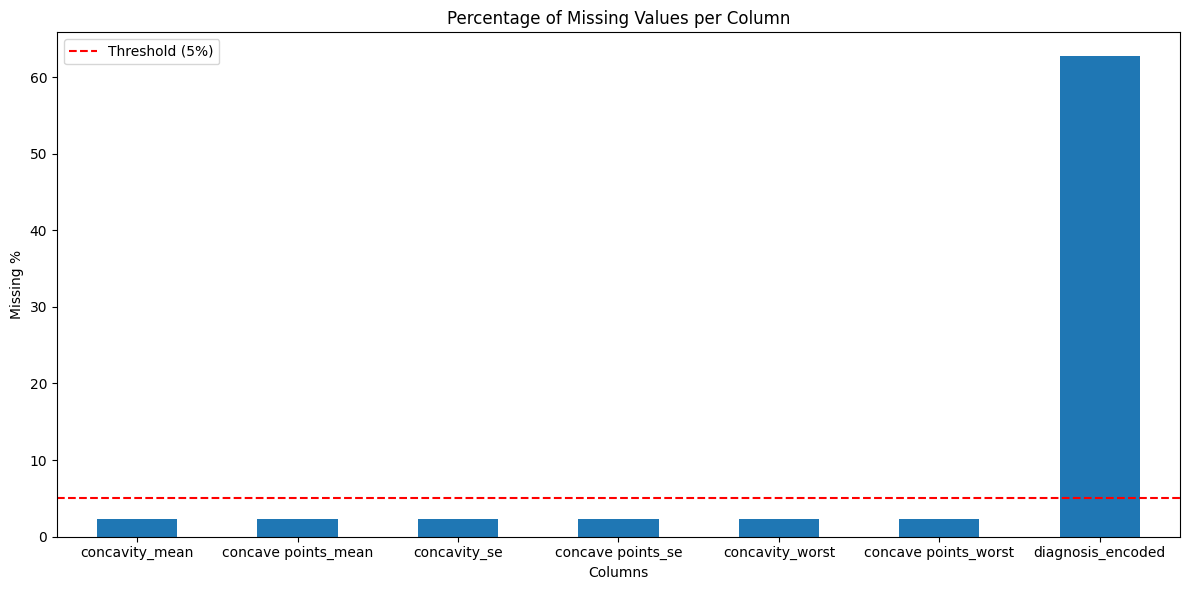

In [215]:
if total_missing > 0:
    plt.figure(figsize=(12, 6))
    ((zero_counts/len(dfn))*100)[((zero_counts/len(dfn))*100) > 0].plot(kind='bar')
    plt.title('Percentage of Missing Values per Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing %')
    plt.xticks(rotation=0, ha='center')
    plt.axhline(y=5, color='r', linestyle='--', label='Threshold (5%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

This visualizes which columns have significant "missing" data (e.g., zeros as proxies for NaNs), helping decide on imputation strategies (e.g., drop columns >5%, fill with median)

In [186]:
#define in which columns to look for missing values.
dfn = dfn.dropna(subset=['diagnosis_encoded'])

Focus on the 192th element in the before and after imputation 

In [187]:
zero2NaN = ['concavity_se', 'concave points_se']
dfgap = dfn.copy()  # work on a copy not affecting original data
for col in zero2NaN:
    dfgap[col] = dfgap[col].replace(0, np.nan)
print("Missing values per column:\n", dfgap.isnull().sum())  # Counts NaN per column
print("\nTotal missing:", dfgap.isnull().sum().sum())
print("\nMissing percentage:\n", (dfgap.isnull().sum() / len(dfgap)) * 100)

Missing values per column:
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                13
concave points_se           13
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32

In [188]:
imputer = SimpleImputer(strategy='median')
dfimputed = dfgap.copy()
dfimputed[zero2NaN] = imputer.fit_transform(dfgap[zero2NaN])
print("\n=== After Median Imputation ===")
print("Missing values per column (should be 0):\n", dfimputed.isnull().sum())
print("\nSample Before/After Imputation (approx 200 rows, concavity_se column):")
print("Before:\n", dfgap['concavity_se'].head(n=195))
print("After:\n", dfimputed[ 'concavity_se'].head(n=195))
# save cleaned data
dfimputed.to_csv('F_CANCER.csv', index=False)


=== After Median Imputation ===
Missing values per column (should be 0):
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst            

In [189]:
zero2NaN = ['concavity_worst', 'concave points_worst']
dfgap = dfn.copy()  # work on a copy not affecting original data
for col in zero2NaN:
    dfgap[col] = dfgap[col].replace(0, np.nan)
print("Missing values per column:\n", dfgap.isnull().sum())  # Counts NaN per column
print("\nTotal missing:", dfgap.isnull().sum().sum())
print("\nMissing percentage:\n", (dfgap.isnull().sum() / len(dfgap)) * 100)

Missing values per column:
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst             13
concave points_worst        13
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32

In [190]:
imputer = SimpleImputer(strategy='most_frequent')
dfimputed = dfgap.copy()
dfimputed[zero2NaN] = imputer.fit_transform(dfgap[zero2NaN])
print("\n=== After Mode Imputation ===")
print("Missing values per column (should be 0):\n", dfimputed.isnull().sum())
print("\nSample Before/After Imputation (approx 200 rows, concavity_worst column):")
print("Before:\n", dfgap['concavity_worst'].head(n=195))
print("After:\n", dfimputed[ 'concavity_worst'].head(n=195))
# save cleaned data
dfimputed.to_csv('F_CANCER.csv', index=False)


=== After Mode Imputation ===
Missing values per column (should be 0):
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst              

In [191]:
zero2NaN = ['concavity_mean', 'concave points_mean']
dfgap = dfn.copy()  # work on a copy not affecting original data
for col in zero2NaN:
    dfgap[col] = dfgap[col].replace(0, np.nan)
print("Missing values per column:\n", dfgap.isnull().sum())  # Counts NaN per column
print("\nTotal missing:", dfgap.isnull().sum().sum())
print("\nMissing percentage:\n", (dfgap.isnull().sum() / len(dfgap)) * 100)

Missing values per column:
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean              13
concave points_mean         13
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32

In [192]:
imputer = SimpleImputer(strategy='mean')
dfimputed = dfgap.copy()
dfimputed[zero2NaN] = imputer.fit_transform(dfgap[zero2NaN])
print("\n=== After Mean Imputation ===")
print("Missing values per column (should be 0):\n", dfimputed.isnull().sum())
print("\nSample Before/After Imputation (approx 200 rows, concavity mean column):")
print("Before:\n", dfgap['concavity_mean'].head(n=195))
print("After:\n", dfimputed[ 'concavity_mean'].head(n=195))
# save cleaned data
dfimputed.to_csv('F_CANCER.csv', index=False)


=== After Mean Imputation ===
Missing values per column (should be 0):
 diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst              

Data-splitting and Scaling

In [193]:

featurecols = [col for col in dfimputed.columns if 'diagnosis' not in col]
#x(features) and y(target)
x = dfimputed[featurecols]
y = dfimputed['diagnosis_encoded']
#Train-test split
x_train, x_val, y_train, y_val = train_test_split(
    x, y, train_size=0.8, stratify=y, random_state=RANDOM_STATE
)
scaler = StandardScaler() 
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_val)
print("Scaling Applied !")
print(f"Train shape: {x_train_scaled.shape}\nTest shape: {x_test_scaled.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True).round(3)}")
print(f"Class balance in test: {y_val.value_counts(normalize=True).round(3)}")

Scaling Applied !
Train shape: (455, 31)
Test shape: (114, 31)
Class balance in train: diagnosis_encoded
0    0.626
1    0.374
Name: proportion, dtype: float64
Class balance in test: diagnosis_encoded
0    0.632
1    0.368
Name: proportion, dtype: float64


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Check that features now have mean ~0(approx.) and std ~1(approx.) (for StandardScaler).

In [194]:
print("\n Feature-Scales After StandardScaler (Train) ")
scale_after_STDSC = pd.DataFrame(x_train_scaled).describe().round(2)
print(scale_after_STDSC)


 Feature-Scales After StandardScaler (Train) 
           0       1       2       3       4       5       6       7       8   \
count  455.00  455.00  455.00  455.00  455.00  455.00  455.00  455.00  455.00   
mean     0.00   -0.00   -0.00    0.00   -0.00   -0.00   -0.00    0.00   -0.00   
std      1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00    1.00   
min     -1.80   -2.22   -1.79   -1.35   -3.06   -1.60   -1.13   -1.24   -2.74   
25%     -0.68   -0.73   -0.69   -0.66   -0.71   -0.76   -0.76   -0.75   -0.72   
50%     -0.24   -0.12   -0.23   -0.30   -0.09   -0.25   -0.30   -0.37   -0.07   
75%      0.46    0.57    0.49    0.35    0.67    0.50    0.39    0.55    0.55   
max      3.91    4.59    3.92    5.13    4.79    3.98    4.30    3.97    3.43   

           9   ...      21      22      23      24      25      26      27  \
count  455.00  ...  455.00  455.00  455.00  455.00  455.00  455.00  455.00   
mean    -0.00  ...    0.00    0.00   -0.00   -0.00   -0.00    0.00 

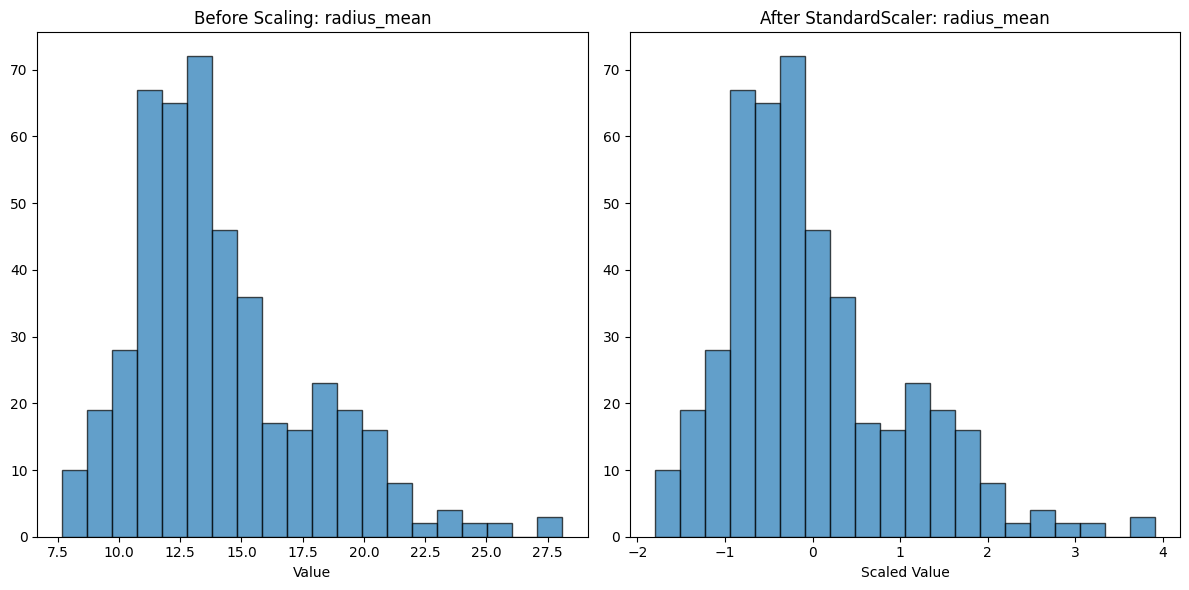

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(x_train['radius_mean'], bins=20, alpha=0.7, edgecolor='black')
ax1.set_title('Before Scaling: radius_mean')
ax1.set_xlabel('Value')
ax2.hist(x_train_scaled[:, featurecols.index('radius_mean')], bins=20, alpha=0.7, edgecolor='black')
ax2.set_title('After StandardScaler: radius_mean')
ax2.set_xlabel('Scaled Value')
plt.tight_layout()
plt.show()


Logisitic Regression(as baseline model)

In [196]:
imputer = SimpleImputer(strategy='median') 
x_train_imputed = imputer.fit_transform(x_train)
x_val_imputed = imputer.transform(x_val)
# Re-scale 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_val_scaled = scaler.transform(x_val_imputed)
# 0 NaNs left
print("NaNs after handling - x_train_scaled:", np.isnan(x_train_scaled).sum())
print("NaNs after handling - y_train:", y_train.isnull().sum())
print("NaNs after handling - x_val_scaled:", np.isnan(x_val_scaled).sum())
print("NaNs after handling - y_val:", y_val.isnull().sum())

NaNs after handling - x_train_scaled: 0
NaNs after handling - y_train: 0
NaNs after handling - x_val_scaled: 0
NaNs after handling - y_val: 0


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [197]:
LGmodel = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
LGmodel.fit(x_train_scaled, y_train)  
#predict 
y_pred = LGmodel.predict(x_val_scaled)  # Use scaled
#accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Accuracy (0-1 range): {acc:.3f}")
print(f"Accuracy (percentage): {acc * 100:.3f}%")
print("Model trained successfully!")


Accuracy (0-1 range): 0.974
Accuracy (percentage): 97.368%
Model trained successfully!


Confusion Matrix

In [198]:
cm = confusion_matrix(y_val, y_pred)
print("Raw Confusion Matrix")
print(cm)
print("\n- TN (True Negatives):", cm[0, 0], " (Correct Benign)")
print("- FP (False Positives):", cm[0, 1], " (Benign as Malignant)")
print("- FN (False Negatives):", cm[1, 0], " (Malignant as Benign)")
print("- TP (True Positives):", cm[1, 1], " (Correct Malignant)")

total = cm.sum()
accuracy = (cm[0, 0] + cm[1, 1]) / total
precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
print(f"\nDerived Metrics (for Malignant=1):")
print(f"Precision: {precision_1:.3f}")
print(f"Recall: {recall_1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Raw Confusion Matrix
[[71  1]
 [ 2 40]]

- TN (True Negatives): 71  (Correct Benign)
- FP (False Positives): 1  (Benign as Malignant)
- FN (False Negatives): 2  (Malignant as Benign)
- TP (True Positives): 40  (Correct Malignant)

Derived Metrics (for Malignant=1):
Precision: 0.976
Recall: 0.952
Accuracy: 0.974


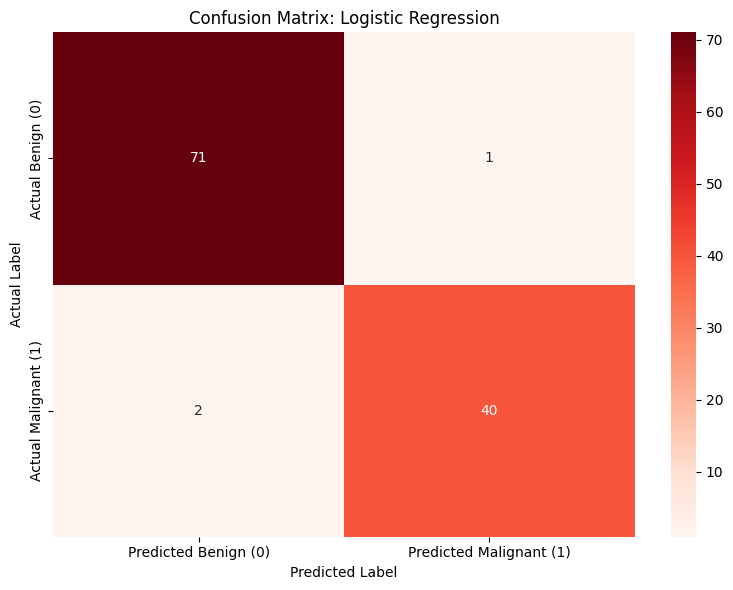

In [199]:
#visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Predicted Benign (0)', 'Predicted Malignant (1)'], 
            yticklabels=['Actual Benign (0)', 'Actual Malignant (1)'])
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()


The function given below is to print the medical metrics such as precision , accuracy , recall ,f1-score , support , auc-roc for the models efficiently

In [200]:
def print_MM(y_val, y_pred, y_pred_prob, model_name):   # MM -> medical metrics such as accuracy , precision , recall , f1-score , support , auc-roc
    print(f"\n=== {model_name} Metrics (Validation Set) ===")
    #evaluate
    # accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"1.Accuracy: {accuracy:.4f}")
    # precision ,recall ,f1-score
    print("\n2.Classification Report:")
    print(classification_report(y_val, y_pred,target_names=['Benign(0)','Malignant(1)']))
    #auc-roc
    auc = roc_auc_score(y_val, y_pred_prob)
    print(f"3.AUC-ROC: {auc:.3f}\n")

    #confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    print(f"Confusion Matrix:\n{cm}")
    print(f"FN (Missed Malignant): {cm[1, 0]}")
    print(f"FP (False Alarm Benign): {cm[0, 1]}")
    return {'Accuracy': {accuracy}}

In [201]:
def compute_and_display_cm(y_val, y_pred, model_name="Model", plot=False, figsize=(10, 4)):
   cm = confusion_matrix(y_val, y_pred)
   cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   if plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
    #row matrix ( just a matrix representation)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax1,
                    xticklabels=['Pred Benign (0)', 'Pred Malignant (1)'],
                    yticklabels=['Actual Benign (0)', 'Actual Malignant (1)'])
    ax1.set_title(f'{model_name} - Raw CM')
        
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Reds', ax=ax2,
                    xticklabels=['Pred Benign (0)', 'Pred Malignant (1)'],
                    yticklabels=['Actual Benign (0)', 'Actual Malignant (1)'])
    ax2.set_title(f'{model_name} - Normalized CM (%)')
        
    plt.tight_layout()
    plt.show()
    
    return cm, cm_norm

SVM

In [202]:
#train the model 
models = {}
svm_model = SVC(kernel='rbf', C=1.0, random_state=RANDOM_STATE, probability=True, class_weight='balanced')
svm_model.fit(x_train_scaled, y_train)

print("Model trained !")

Model trained !



=== SVM (Balanced) Metrics (Validation Set) ===
1.Accuracy: 0.9737

2.Classification Report:
              precision    recall  f1-score   support

   Benign(0)       0.97      0.99      0.98        72
Malignant(1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

3.AUC-ROC: 0.997

Confusion Matrix:
[[71  1]
 [ 2 40]]
FN (Missed Malignant): 2
FP (False Alarm Benign): 1


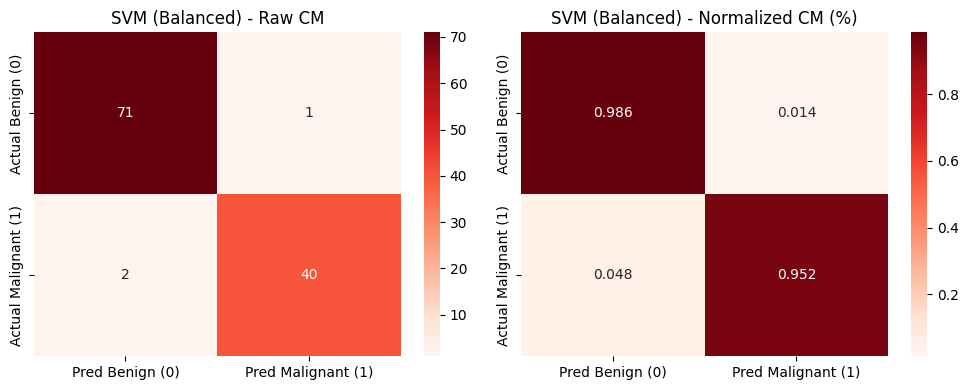

In [203]:
#evaluate
#prediction & probabilities
y_pred_svm = svm_model.predict(x_val_scaled)
y_prob_svm = svm_model.predict_proba(x_val_scaled)[:, 1]
#precision,accuracy,f1-score,support,recall,auc-roc
models['SVM'] = print_MM(y_val, y_pred_svm, y_prob_svm, "SVM (Balanced)")
#confusion matrix
cm_svm = compute_and_display_cm(y_val, y_pred_svm, "SVM (Balanced)",plot = True)


Random Forest

In [204]:
#train the model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
rf_model.fit(x_train_scaled, y_train)

print("Model trained !")

Model trained !



=== Random Forest (Balanced) Metrics (Validation Set) ===
1.Accuracy: 0.9561

2.Classification Report:
              precision    recall  f1-score   support

   Benign(0)       0.97      0.96      0.97        72
Malignant(1)       0.93      0.95      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

3.AUC-ROC: 0.992

Confusion Matrix:
[[69  3]
 [ 2 40]]
FN (Missed Malignant): 2
FP (False Alarm Benign): 3


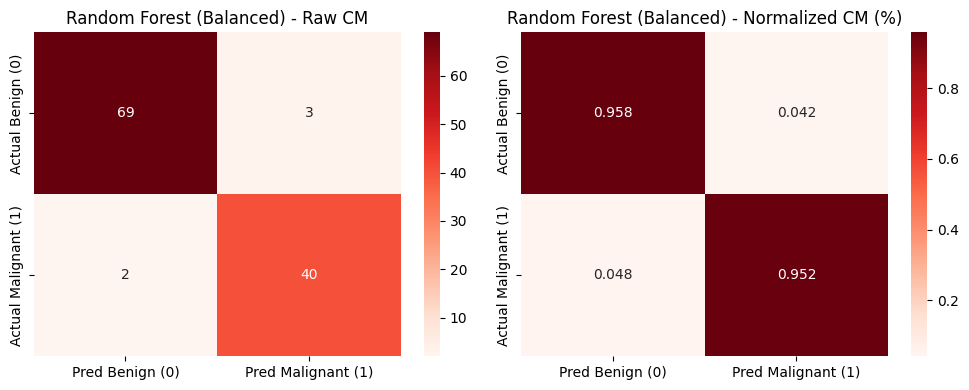

In [205]:
#evaluate
#prediction & probabilities
y_pred_rf = rf_model.predict(x_val_scaled)
y_prob_rf = rf_model.predict_proba(x_val_scaled)[:, 1]
#precision,accuracy,f1-score,support,recall,auc-roc
models['RF'] = print_MM(y_val, y_pred_rf, y_prob_rf, "Random Forest (Balanced)")
#confusion matrix
cm_rf = compute_and_display_cm(y_val, y_pred_rf, "Random Forest (Balanced)",plot = True)

XGBOOST

In [206]:
#train model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()  # ~1.68
xgb_model = XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(x_train_scaled, y_train)

print("Model trained !")

Model trained !



=== XGBoost (Balanced) Metrics (Validation Set) ===
1.Accuracy: 0.9474

2.Classification Report:
              precision    recall  f1-score   support

   Benign(0)       0.99      0.93      0.96        72
Malignant(1)       0.89      0.98      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

3.AUC-ROC: 0.992

Confusion Matrix:
[[67  5]
 [ 1 41]]
FN (Missed Malignant): 1
FP (False Alarm Benign): 5


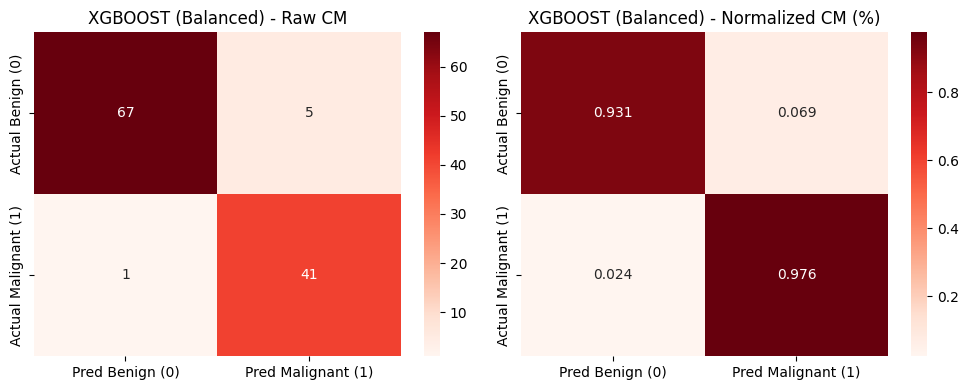

In [207]:
#evaluate
#prediction & probabilities
y_pred_xgb = xgb_model.predict(x_val_scaled)
y_prob_xgb = xgb_model.predict_proba(x_val_scaled)[:, 1]
#precision,accuracy,f1-score,support,recall,auc-roc
models['XGBoost'] = print_MM(y_val, y_pred_xgb, y_prob_xgb, "XGBoost (Balanced)")
#confusion matrix
cm_svm = compute_and_display_cm(y_val, y_pred_xgb, "XGBOOST (Balanced)",plot = True)

Revised Classification report

In [208]:
model_names = ['SVM', 'RF', 'XGBoost']
y_preds = {'SVM': y_pred_svm, 'RF': y_pred_rf, 'XGBoost': y_pred_xgb}
print("\n Full Classification Reports ")
for model_name in model_names:
    print(f"\n{model_name} Report:")
    y_pred = y_preds[model_name]
    print(classification_report(y_val, y_pred, target_names=['Benign(0)', 'Malignant(1)']))



 Full Classification Reports 

SVM Report:
              precision    recall  f1-score   support

   Benign(0)       0.97      0.99      0.98        72
Malignant(1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


RF Report:
              precision    recall  f1-score   support

   Benign(0)       0.97      0.96      0.97        72
Malignant(1)       0.93      0.95      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


XGBoost Report:
              precision    recall  f1-score   support

   Benign(0)       0.99      0.93      0.96        72
Malignant(1)       0.89      0.98      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
w

Best performed model acc. to accuracy as well as f1-score is SVM

In [209]:
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Grid for tuning 
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization (low: underfit, high: overfit)
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]  # Kernel coefficient (scale/auto: 1/n_features ~0.033)
}
# GridSearchCV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
svm_tuned = SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True, class_weight='balanced')
grid_search = GridSearchCV(estimator=svm_tuned, param_grid=param_grid, scoring='roc_auc', 
cv=cv, n_jobs=-1, verbose=1, return_train_score=True)
grid_search.fit(x_train_scaled, y_train)
# Best params and score
print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV ROC_AUC: {grid_search.best_score_:.3f}")
# Best model on full train
best_svm = grid_search.best_estimator_
y_pred_tuned = best_svm.predict(x_val_scaled)
y_prob_tuned = best_svm.predict_proba(x_val_scaled)[:, 1]
# Evaluate tuned model on val
print("\nTuned SVM")
models['SVM_Tuned'] = print_MM(y_val, y_pred_tuned, y_prob_tuned, "SVM Tuned")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'C': 1, 'gamma': 'scale'}
Best CV ROC_AUC: 0.996

Tuned SVM

=== SVM Tuned Metrics (Validation Set) ===
1.Accuracy: 0.9737

2.Classification Report:
              precision    recall  f1-score   support

   Benign(0)       0.97      0.99      0.98        72
Malignant(1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

3.AUC-ROC: 0.997

Confusion Matrix:
[[71  1]
 [ 2 40]]
FN (Missed Malignant): 2
FP (False Alarm Benign): 1


In [210]:
dfn.to_csv('Fs_cancer_data.csv', index=False)